In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from Code import Algo2
from Code import Algo1
from Code import ULA
from sklearn.preprocessing import PolynomialFeatures
from joblib import Parallel, delayed
from Code import ZVnbrosse

In [2]:
import importlib
importlib.reload(Algo2)

<module 'Code.Algo2' from '/home/nurlan/Documents/_Research/VR-MCMC/Code/Algo2.py'>

In [3]:
dim = 1
h = 0.1
   
def f_grad(x):
    a = 1 / np.sqrt(2)
    return x-a+2*a/(1 + np.exp(2* (x * a)))

def f(x):
    a = 1 / np.sqrt(2)
    return 1/2 * (x-a)**2 - np.log(1 + np.exp(-2 * x * a))

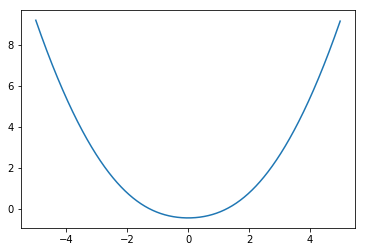

In [4]:
t = np.arange(-5, 5, 0.01)
s = np.array(list(map(f, t)))

plt.plot(t, s)
plt.show()

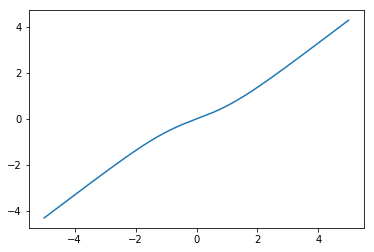

In [5]:
t = np.arange(-5.0, 5.0, 0.01)
s = np.array(list(map(f_grad, t)))

plt.plot(t, s)
plt.show()

### Structure of $\bar{Q}_{l,n}(x)$

$$\bar{Q}_{l,n}^N (x) = \mathbb{E} \left [\sum_{p = l}^{N+n} \frac{1}{n} f(X_p) | X_l = x \right] \quad \forall l = N+1, \dots, N+n$$

In order, to approximate functions $\bar{Q}_{l,n}^N(x)$, for all $l$ I generated trajectories started from each point of the grid and estimated the functions. Particularly:

we have grid on $I = \left[-5,  5 \right]$

for each point $x \in I$, for each $l$ I generated $N_{train} = 100 $ trajectories of length $n+N-l$:

$$X^{x, (i)}_0 = x$$

$$X^{x, (i)}_p = X_{p-1}^{x,(i)} - h  \mu( X_{p-1}^{x,(i)}) + \sqrt{h} Z_p^{(i)}$$

$$ \forall p = 1, \dots, n \text{ and }  i = 1, \dots , N_{train}$$

Then I estimate:
$$\bar{Q}_{l, n}^N (x) = \frac{1}{N_{train}} \sum_{i = 1}^{N_{train}}\sum_{p = 0}^{n-l} \frac{1}{n} X_p^{x, (i)} \quad \forall x \in I$$

In [154]:
n = 500
N_train = 50

grid = np.arange(-5,5,0.2)

def q_l_by_grid(grid, l, n, N_train, h):
    np.random.seed(l)
    noise = np.random.randn(N_train, n-l)
    trajectories_on_grid = np.zeros((grid.shape[0], N_train, n-l))
    for j in range(N_train):
        trajectories_on_grid[:,j,0] = grid
    for i in range(grid.shape[0]):
        for j in range(N_train):
            for m in range(1,n-l):
                trajectories_on_grid[i,j,m] = trajectories_on_grid[i,j,m-1] - h/2 * f_grad(trajectories_on_grid[i,j,m-1]) \
                    + np.sqrt(h) * noise[j,m]
    return ((trajectories_on_grid[:,:,1:]).sum(axis = 2) / n).mean(axis = 1) + grid/n
#     return trajectories_on_grid

In [17]:
Q_grid = np.zeros((n, grid.shape[0]))
for l in tqdm(range(n)):
    Q_grid[l] = q_l_by_grid(grid, l, n, N_train, h)

100%|██████████| 500/500 [26:09<00:00,  3.14s/it]


In [8]:
np.save('Q_grid.npy', Q_grid)

In [8]:
# Q_grid = np.load('Q_grid.npy')

#### Some plots for $\bar{Q}_{l,n} (x)$ for $l \in \left\{1, 20, 50, 100,150,200, 230, 250 \right\}$ and $n = 250$

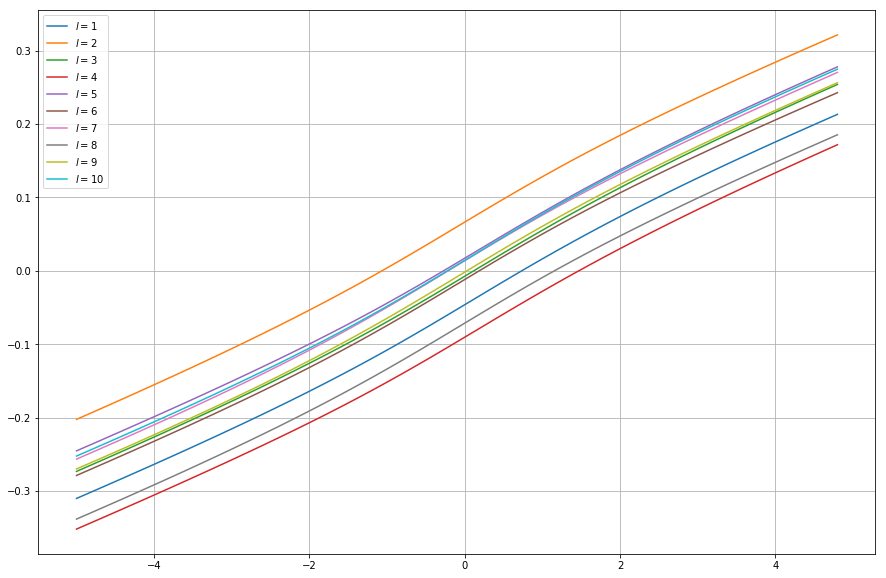

In [13]:
plt.figure(figsize=(15,10))

for l in range(10):
    plt.plot(grid, Q_grid[l], label = r"$l = {}$".format(l+1))
plt.legend()
plt.grid()
# plt.xlim(-1,1)
plt.show()

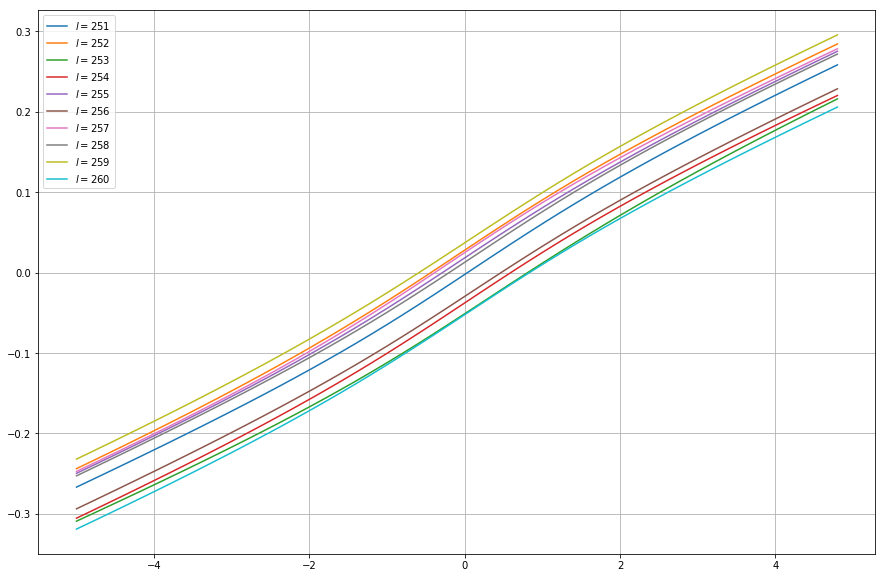

In [14]:
plt.figure(figsize=(15,10))

for l in range(250, 260):
    plt.plot(grid, Q_grid[l], label = r"$l = {}$".format(l+1))
plt.legend()
plt.grid()
# plt.xlim(-1,1)
plt.show()

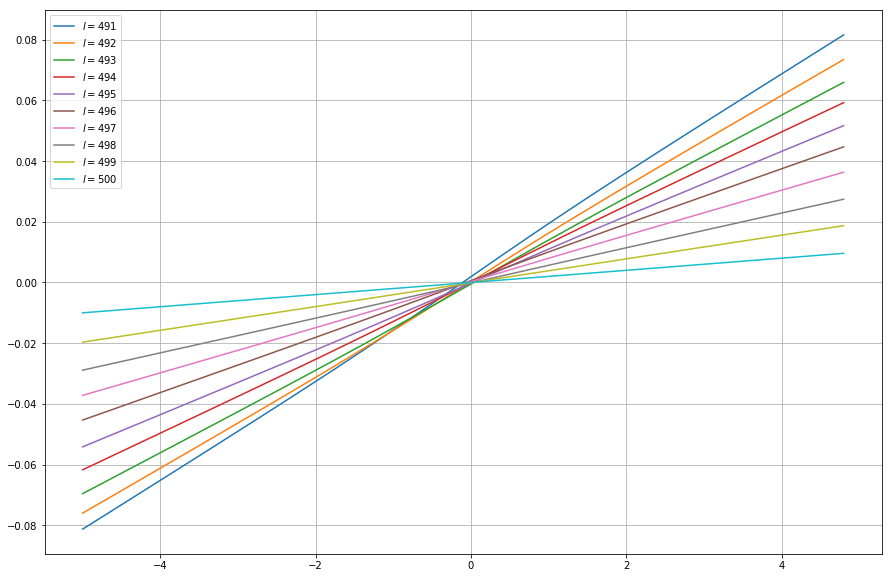

In [12]:
plt.figure(figsize=(15,10))

for l in range(490, 500):
    plt.plot(grid, Q_grid[l], label = r"$l = {}$".format(l+1))
plt.legend()
plt.grid()
# plt.xlim(-1,1)
plt.show()

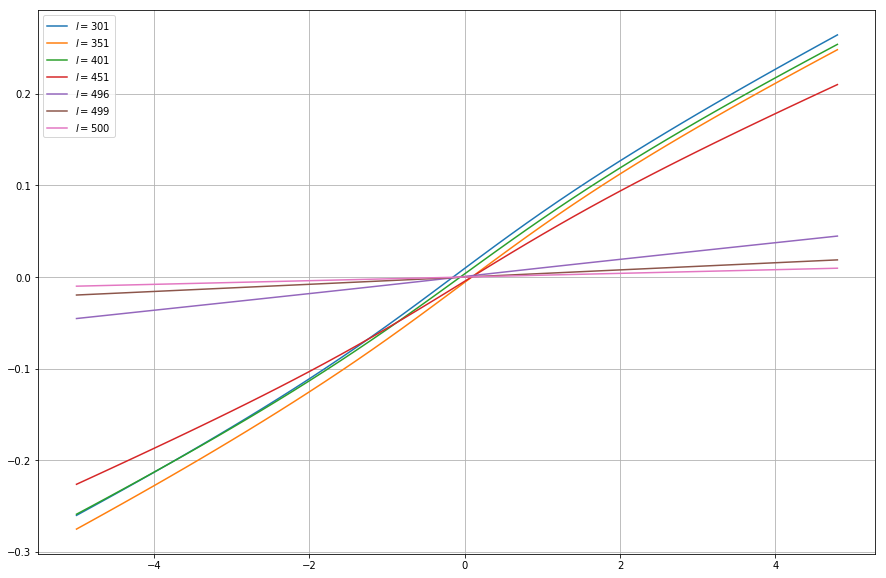

In [15]:
plt.figure(figsize=(15,10))

for l in [300, 350, 400, 450, 495, 498, 499]:
    plt.plot(grid, Q_grid[l], label = r"$l = {}$".format(l+1))
plt.legend()
plt.grid()
# plt.xlim(-1,1)
plt.show()

#### Define function $\tilde{\bar{Q}}_{l,n}(x)$, which finds $i$ such that: $x_i < x < x_{i+1}$ where $x_i, x_{i+1} \in I$

$$\tilde{\bar{Q}}_{l,n}(x) = \frac{\bar{Q}_{l,n}(x_i) + \bar{Q}_{l,n}(x_{i+1})}{2}$$

In [97]:
def Q_l(grid, Q_grid, x, l):
    pos = np.searchsorted(grid, x)
#     print (pos)
    if pos > 0:
        return Q_grid[l, pos-1:pos+1].mean()
    else:
        return 0.0

### Comparison with approximation using regression on pregenerated train trajectories

In [21]:
np.random.seed(2342)
X, G, Z = ULA.ULA_with_burnin(d=dim, step=h, burn_in=10000, n=1000000,f_grad=f_grad)

In [22]:
def local_weighted_estimator(X):
    return X.sum(axis=1).mean()

In [24]:
np.random.seed(123)

XX, GG, ZZ = ULA.generate_train_trajectories(X, N_train=1000,d = dim, step = h, n = n, f_grad=f_grad)

In [111]:
import importlib
importlib.reload(Algo2)

<module 'Code.Algo2' from '/home/yerlan.turashev/Paper/VR-MCMC/Code/Algo2.py'>

In [120]:
deg = 1
Betas, degrees = Algo2.Q_l_fit(XX, f_target="sum", max_deg = deg)

100%|██████████| 500/500 [00:01<00:00, 314.80it/s]


In [122]:
def Q_l_predict(x, l, Betas, max_deg):
    poly = PolynomialFeatures(max_deg)
    x_pol = poly.fit_transform(np.array(x).reshape(1,-1))
    beta = Betas[l]
    return (x_pol @ beta)

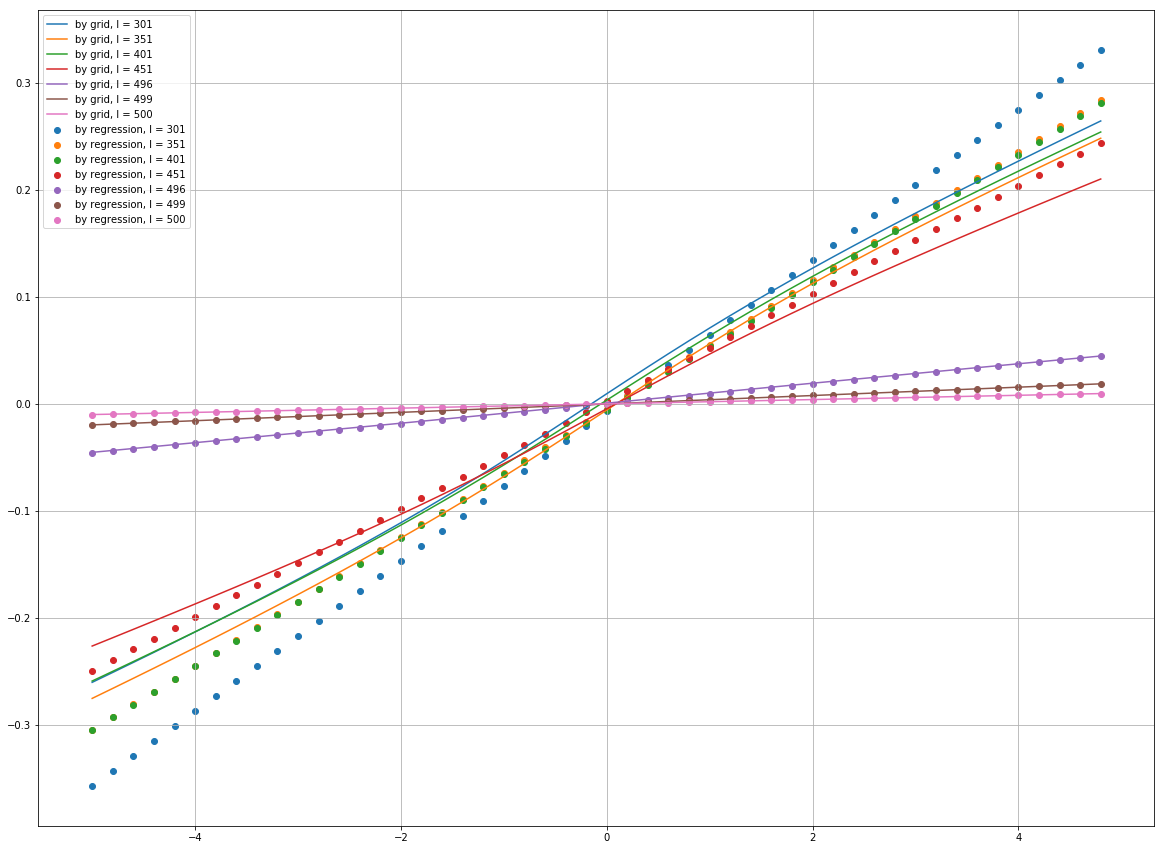

In [123]:
plt.figure(figsize=(20,15))
q_l_predict_plot = np.zeros_like(grid)

for l in [300, 350, 400, 450, 495, 498, 499]:
    for i in range(grid.shape[0]):
        q_l_predict_plot[i] = Q_l_predict(grid[i], l, Betas, deg) 
    plt.plot(grid, Q_grid[l], label = "by grid, l = {}".format(l+1))
    plt.scatter(grid, q_l_predict_plot, label = "by regression, l = {}".format(l+1), )
plt.legend()
plt.grid()
plt.show()

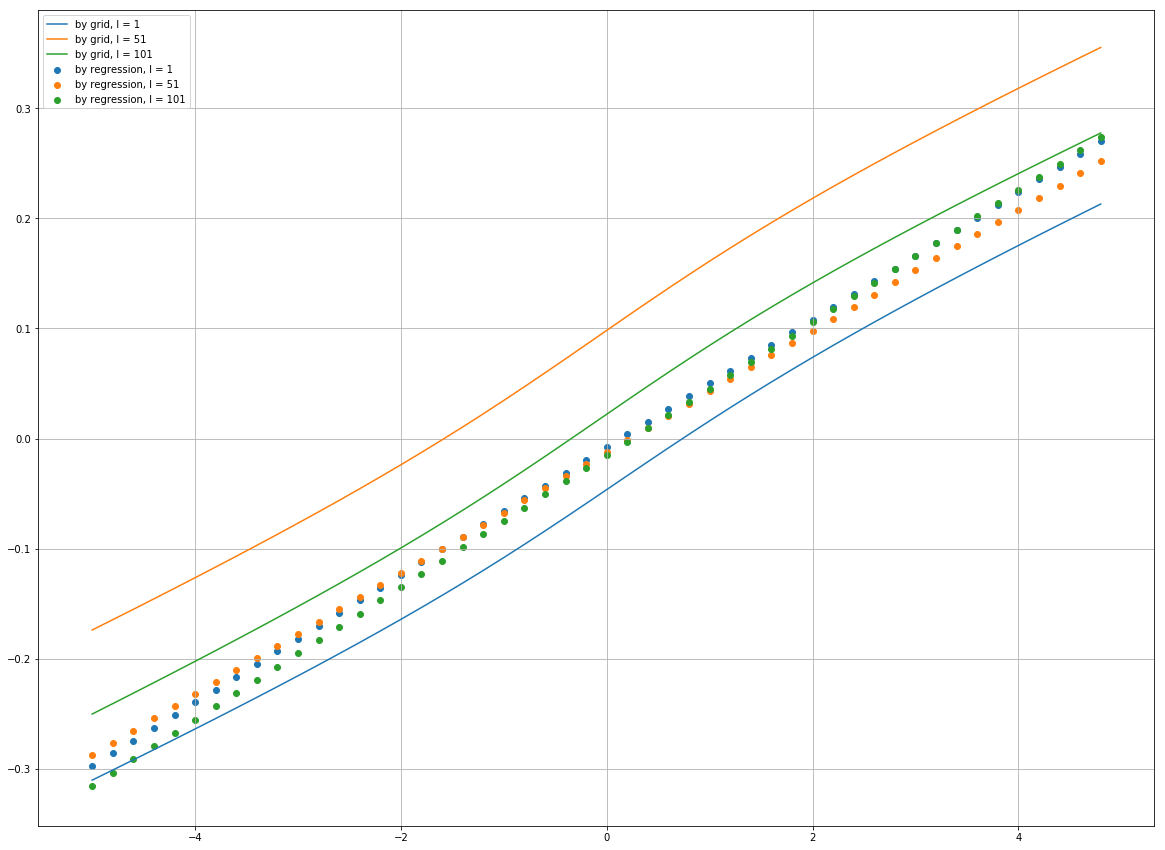

In [124]:
plt.figure(figsize=(20,15))
q_l_predict_plot = np.zeros_like(grid)

for l in [0, 50, 100]:
    for i in range(grid.shape[0]):
        q_l_predict_plot[i] = Q_l_predict(grid[i], l, Betas, deg) 
    plt.plot(grid, Q_grid[l], label = "by grid, l = {}".format(l+1))
    plt.scatter(grid, q_l_predict_plot, label = "by regression, l = {}".format(l+1), )
plt.legend()
# plt.xlim(-3,3)
plt.grid()
plt.show()

## "Ground truth" result for dimension 1
####  Suppose we have markov chain with gaussian mixture distribution:

$X_1, X_2, \dots, X_n$

where $n$ = 500

$f(x) = x$

$\gamma_i = h$

### Step 1. 

Suppose we have estimation for $\bar{Q}_{l, n}(x) \quad \forall l $ on grid 

### Step 2

$$a_{l,n}^k(x) = \mathbb{E}_{\xi} \left[ \phi_k(\xi) \bar{Q}_{l,n} (x - h\mu(x) + \sqrt{h}\xi)\right]= \int_{-\infty}^{\infty} \phi_k(y) \bar{Q}_{l,n} (x - h\mu(x) + \sqrt{h}y) \varphi(y) dy$$

where $$\varphi(y) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{y^2}{2}}$$

Explicit Integration

In [149]:
from scipy.integrate import quad
from scipy.stats import multivariate_normal as mvnorm

def integrand(y, x, x_grad, l):
    x_next = np.array([x - h/2 * x_grad + np.sqrt(h) * y])
    return Q_l(grid, Q_grid, x_next[0], l) * y * mvnorm.pdf(y, mean=0, cov=1)

def a_lk_explicit(x, x_grad, l):
    return quad(integrand, -4, 4, args=(x,x_grad,l))[0]

def M_bias_gt(traj, traj_grad, traj_noise):
    S = 0
    for k in range (1):
        for i in range(1,traj.shape[0]):
            S = S + a_lk_explicit(traj[i-1], traj_grad[i-1], i) *  Algo2.H(1,traj_noise[i])
    return S

def estimator_gt(test_traj, test_traj_grad, test_traj_noise, n_jobs = 8):
    N_test = test_traj.shape[0]
    M_results = Parallel(n_jobs = n_jobs)(delayed(M_bias_gt)(test_traj[i], test_traj_grad[i], test_traj_noise[i])for i in range(N_test))
    return np.array(M_results).reshape(-1)

/home/nurlan/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



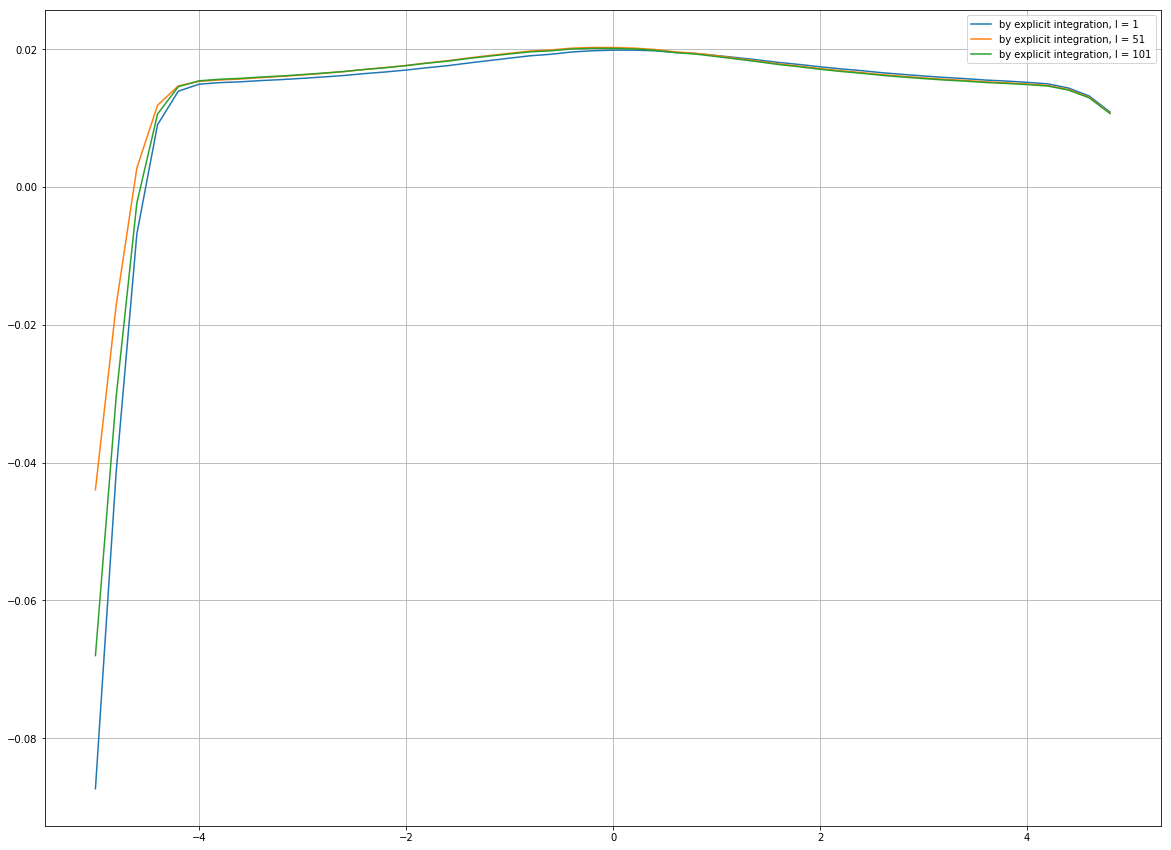

In [98]:
plt.figure(figsize=(20,15))
a_lk_explicit_plot = np.zeros_like(grid)
for l in [0, 50, 100]:
    for i in range(grid.shape[0]):
        a_lk_explicit_plot[i] = a_lk_explicit(grid[i],f_grad(grid[i]), l) 
    plt.plot(grid, a_lk_explicit_plot, label = "by explicit integration, l = {}".format(l+1))
plt.legend()
# plt.xlim(-3,3)
plt.grid()
plt.show()

In [62]:
def estimator(XX):
    Pi = np.empty(XX.shape[0])
    for i in tqdm(range(XX.shape[0])):
        Pi[i] = local_weighted_estimator(XX[i])
    return Pi

In [64]:
np.random.seed(123)
N_test = 50
XX_test, GG_test, ZZ_test = ULA.generate_test_trajetories(N_test=N_test, d =dim, step=h, 
                                                          burn_in=10000, n = n, f_grad=f_grad)

In [65]:
P_test = estimator(XX_test)

100%|██████████| 50/50 [00:00<00:00, 53227.21it/s]


In [66]:
M_test_gt = estimator_gt(XX_test, GG_test, ZZ_test)

In [125]:
M_test_reg = Algo2.estimator_bias(np.array([[1]], dtype=np.int16),XX_test, GG_test, ZZ_test,h, degrees, Betas, n_jobs=8)

In [126]:
def ZVpolyOne(traj, traj_grad):
    n, d = traj.shape
    samples = traj.sum(axis = 1).reshape(-1,1)
    cov1 = np.var(traj_grad)
    A = 1 / cov1
    covariance = np.cov(np.concatenate((-traj_grad, samples), axis=1), rowvar=False)
    paramZV1 = -np.dot(A,covariance[:d, d:])
    ZV1 = samples - np.dot(traj_grad, paramZV1)
    mean_ZV1 = np.mean(ZV1, axis = 0)
    return mean_ZV1

res_zv_1 = []
for i in range (XX_test.shape[0]):
    res_zv_1.append(ZVpolyOne(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim)))
res_zv_1 = np.array(res_zv_1).reshape(-1)

res_zv_2 = []
for i in range (XX_test.shape[0]):
    res_zv_2.append(ZVnbrosse.ZVpolyTwo(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim),"sum"))
res_zv_2 = np.array(res_zv_2).reshape(-1)

res_cv_1 = []
for i in range (XX_test.shape[0]):
    res_cv_1.append(ZVnbrosse.CVpolyOne(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim),"sum"))
res_cv_1 = np.array(res_cv_1).reshape(-1)

res_cv_2 = []
for i in range (XX_test.shape[0]):
    res_cv_2.append(ZVnbrosse.CVpolyTwo(XX_test[i].reshape(-1,dim), GG_test[i].reshape(-1,dim), "sum"))
res_cv_2 = np.array(res_cv_2).reshape(-1)

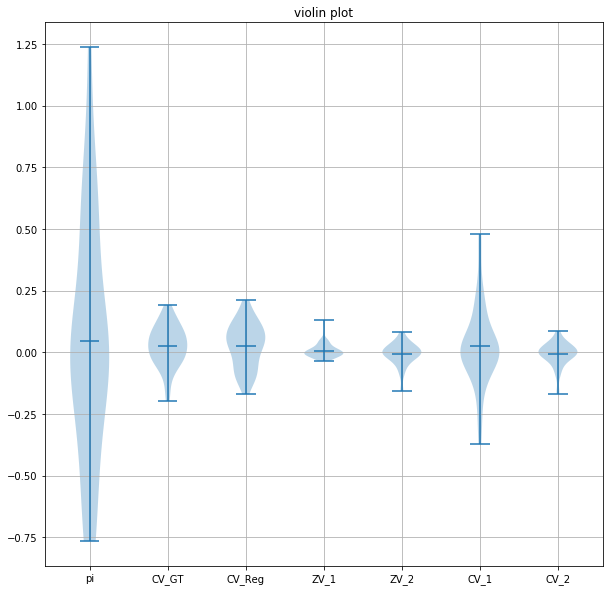

In [127]:
all_data = [P_test]
# all_data = []
all_data.append(P_test - M_test_gt)
all_data.append(P_test - M_test_reg)
all_data.append(res_zv_1)
all_data.append(res_zv_2)
all_data.append(res_cv_1)
all_data.append(res_cv_2)
    
plt.figure(figsize=(10,10))
plt.violinplot(all_data, showmeans=True, showmedians=False)
plt.title('violin plot')
plt.xticks(np.arange(1,8), ('pi', 'CV_GT','CV_Reg',  'ZV_1', 'ZV_2', 'CV_1', 'CV_2'))
# plt.xticks(np.arange(1,6), ('CV_B', 'ZV_1', 'ZV_2', 'CV_1', 'CV_2'))
plt.grid()
plt.show()

In [131]:
print ('Variance of ULA = ', P_test.var(ddof=1))

print ('Variance on test trajectories using grid + explicit integration =',(P_test - M_test_gt).var(ddof = 1))

print ('Variance of ALgo2 (polynomial regression) = ',(P_test - M_test_reg).var(ddof = 1))

Variance of ULA =  0.22058957918570837
Variance on test trajectories using grid + explicit integration = 0.007052443998298889
Variance of ALgo2 (polynomial regression) =  0.008346757937040886


In [83]:
print ('Variance of ALgo1 (polynomial regression) = ',(P_test - M_test_1).var(ddof = 1))
print (res_zv_1.var(ddof = 1))
print (res_cv_1.var(ddof = 1))
print (res_zv_2.var(ddof = 1))
print (res_cv_2.var(ddof = 1))


Variance of ALgo1 (polynomial regression) =  0.006783308046984641
0.0007827832412667212
0.02515375370327398
0.002310442053389251
0.0024640471758201536


In [ ]:
from Code import Algo1

f_target = 'sum'

Betas_1, degrees_1 = Algo1.G_pml_fit_mean(XX,f_target, max_deg = deg)

M_test_1 = Algo1.estimator_bias(np.array([[1]], dtype=np.int16), XX_test, GG_test, ZZ_test, h, degrees_1,Betas_1,100, n_jobs=8)

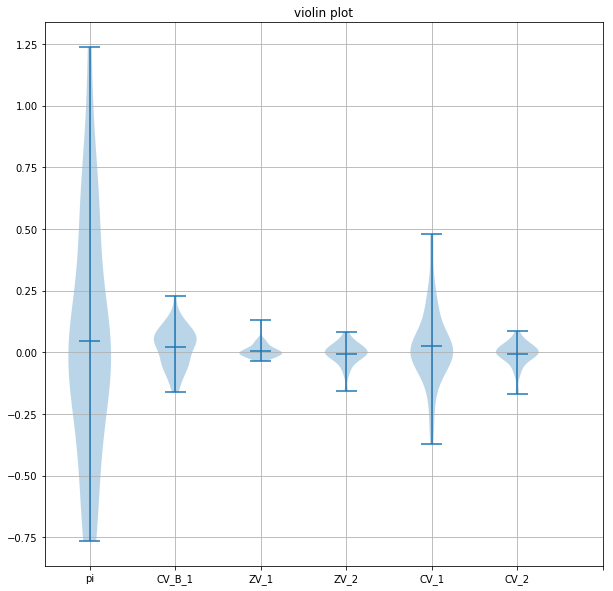

In [80]:
all_data = [P_test]
# all_data = []
all_data.append(P_test - M_test_1)
all_data.append(res_zv_1)
all_data.append(res_zv_2)
all_data.append(res_cv_1)
all_data.append(res_cv_2)
    
plt.figure(figsize=(10,10))
plt.violinplot(all_data, showmeans=True, showmedians=False)
plt.title('violin plot')
plt.xticks(np.arange(1,8), ('pi', 'CV_B_1', 'ZV_1', 'ZV_2', 'CV_1', 'CV_2'))
# plt.xticks(np.arange(1,6), ('CV_B', 'ZV_1', 'ZV_2', 'CV_1', 'CV_2'))
plt.grid()
plt.show()

### $a_{l,k}(x)$

In [132]:
def a_lk_by_grid(grid, l, n, N_train):
    np.random.seed(42)
    noise = np.random.randn(N_train, n-l+1)
    trajectories_on_grid = np.zeros((grid.shape[0], N_train, n-l+1))
    a_lk_on_grid = np.zeros_like(grid)
    for j in range(N_train):
        trajectories_on_grid[:,j,0] = grid
    for i in range(grid.shape[0]):
        for j in range(N_train):
            for m in range(1,n-l):
                trajectories_on_grid[i,j,m] = trajectories_on_grid[i,j,m-1] - h/2 * f_grad(trajectories_on_grid[i,j,m-1]) \
                    + np.sqrt(h) * noise[j,m]
                    
    tmp = trajectories_on_grid[:,:,1:].sum(axis = 2) / n

    for i in range(grid.shape[0]):
        for j in range(N_train):
            tmp[i,j] = tmp[i,j] * noise[j, 0]
            
    return tmp.mean(axis = 1)

In [133]:
a_grid = np.zeros((n, grid.shape[0]))
for l in tqdm(range(1,n)):
    a_grid[l] = a_lk_by_grid(grid, l, n, N_train)

100%|██████████| 499/499 [26:26<00:00,  3.18s/it]


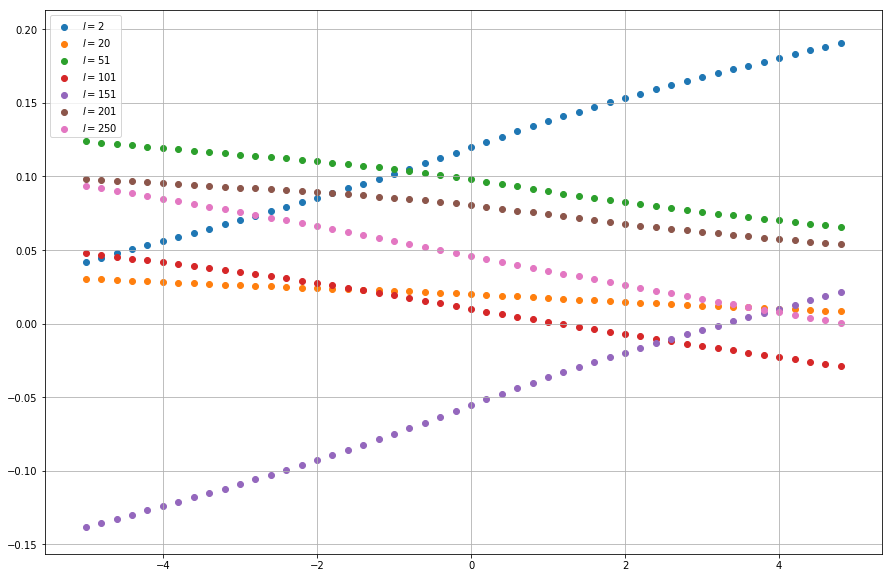

In [134]:
plt.figure(figsize=(15,10))

for l in [1,19,50, 100,150, 200,249]:
    plt.scatter(grid, a_grid[l], label = r"$l = {}$".format(l+1))
plt.legend()
plt.grid()
# plt.xlim(-1,1)
plt.show()

### Analysis of $Q_{p,l}$ and Algo1

$$Q_{p,l}(x) = \mathbb{E} \left[ f(X_p) \mid X_l =x\right]$$

In [175]:
def q_pl_by_grid(grid, p, l, n, N_train, h):
    np.random.seed(l)
    noise = np.random.randn(N_train, p-l+1)
    trajectories_on_grid = np.zeros((grid.shape[0], N_train, p-l+1))
    for j in range(N_train):
        trajectories_on_grid[:,j,0] = grid
    for i in range(grid.shape[0]):
        for j in range(N_train):
            for m in range(1,p-l+1):
                trajectories_on_grid[i,j,m] = trajectories_on_grid[i,j,m-1] - h/2 * f_grad(trajectories_on_grid[i,j,m-1]) \
                    + np.sqrt(h) * noise[j,m]
    return (trajectories_on_grid[:,:,-1]).mean(axis = 1)
#     return trajectories_on_grid

In [174]:
Q_pl_grid = np.zeros((n, grid.shape[0]))
for p in tqdm(range(1,n)):
    Q_pl_grid[p] = q_pl_by_grid(grid, p, 0, n, N_train, h)

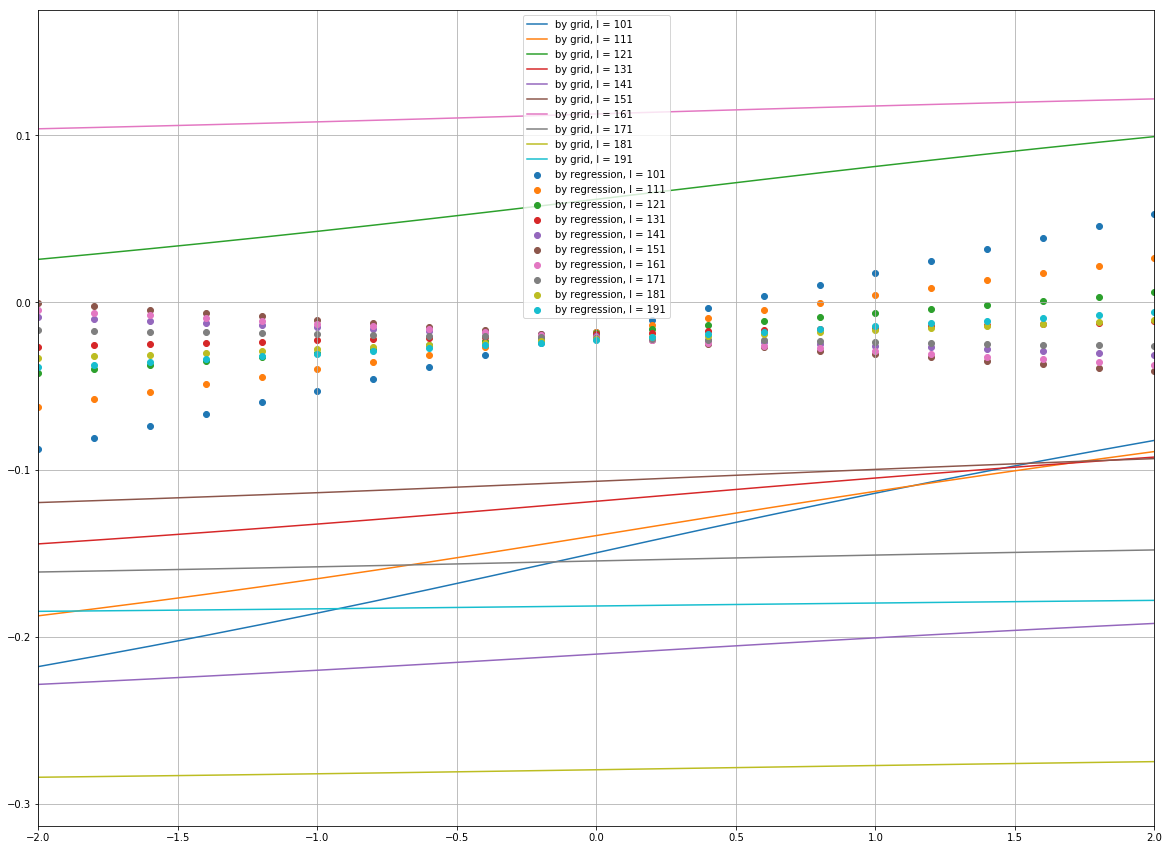

In [218]:
plt.figure(figsize=(20,15))
q_pl_predict_plot = np.zeros_like(grid)

for p in range(100, 200, 10):
    for i in range(grid.shape[0]):
        q_pl_predict_plot[i] = Algo1.G_pml_predict(grid[i], p, Betas_2, deg) 
    plt.plot(grid, Q_pl_grid[p], label = "by grid, l = {}".format(p+1))
    plt.scatter(grid, q_pl_predict_plot, label = "by regression, l = {}".format(p+1), )
plt.legend()
plt.xlim(-2,2)
plt.grid()
plt.show()

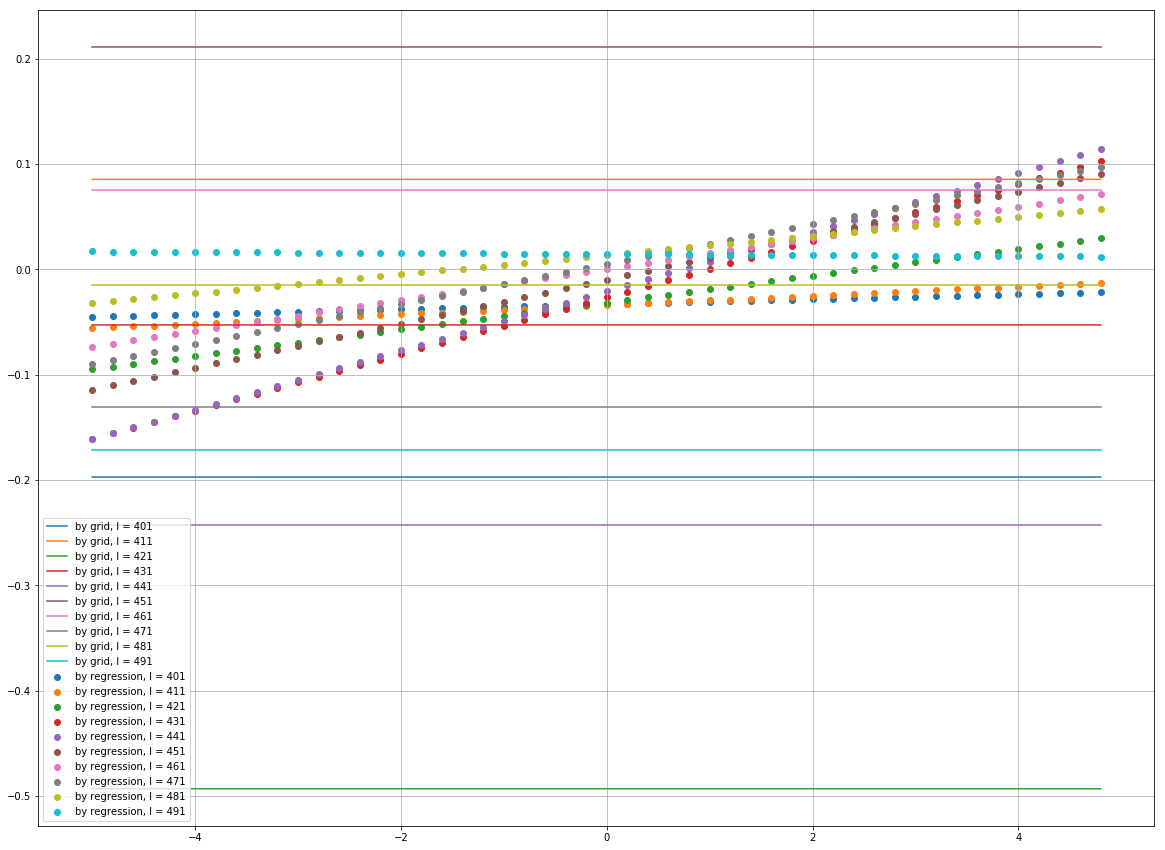

In [219]:
plt.figure(figsize=(20,15))
q_pl_predict_plot = np.zeros_like(grid)

for p in range(400, 500, 10):
    for i in range(grid.shape[0]):
        q_pl_predict_plot[i] = Algo1.G_pml_predict(grid[i], p, Betas_2, deg) 
    plt.plot(grid, Q_pl_grid[p], label = "by grid, l = {}".format(p+1))
    plt.scatter(grid, q_pl_predict_plot, label = "by regression, l = {}".format(p+1), )
plt.legend()
# plt.xlim(-2,2)
plt.grid()
plt.show()

### Ground truth for algo1 ($Q_{p,l}$)

In [244]:
def integrand_2(y, x, x_grad, l):
    x_next = np.array([x - h/2 * x_grad + np.sqrt(h) * y])
    return Q_l(grid, Q_pl_grid, x_next[0], l) * y * mvnorm.pdf(y, mean=0, cov=1)

def a_plk_explicit(x, x_grad, p, l):
    return quad(integrand_2, -4, 4, args=(x,x_grad,p-l))[0]

def M_bias_gt_2(traj, traj_grad, traj_noise, n_tilde = 100):
    S = 0
    for k in range (1):
        for p in range(traj.shape[0]):
            for l in range(p+1):
                if (p-l<n_tilde): 
                    S = S + a_plk_explicit(traj[l-1,0], traj_grad[l-1,0], p, l) *  Algo1.H(1,traj_noise[l])
    return S/traj.shape[0]


def estimator_gt_2(test_traj, test_traj_grad, test_traj_noise, n_jobs = 8):
    N_test = test_traj.shape[0]
    M_results = Parallel(n_jobs = n_jobs)(delayed(M_bias_gt_2)(test_traj[i], test_traj_grad[i], test_traj_noise[i])for i in range(N_test))
    return np.array(M_results).reshape(-1)

In [245]:
import timeit
i_test = 5
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[i_test])
print ("mean of target function =", p)
p = p - M_bias_gt_2(XX_test[i_test],GG_test[i_test], ZZ_test[i_test])
print (p)

mean of target function = 0.09222517697581051


/home/yerlan.turashev/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



[0.02405199]


In [247]:
import timeit
i_test = 5
time_1 = timeit.default_timer()
p = local_weighted_estimator(XX_test[i_test])
print ("mean of target function =", p)
p = p - Algo1.M_bias(np.array([[1]], dtype=np.int16), XX_test[i_test],GG_test[i_test], ZZ_test[i_test], h, degrees_2,Betas_2,100)
print (p)

mean of target function = 0.09222517697581051
0.020029679872896555
